In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

**앙상블 학습(ensemble learning)** : 일련의 예측기로부터 예측을 수집하여 가장 좋은 모델 하나보다 더 좋은 예측을 얻는 방법
+ 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘함(각각 다른 알고리즘으로 학습)

**랜덤 포레스트(random forest)** : 모든 개별 트리의 예측을 구한 뒤 가장 많은 선택을 받은 클래스를 예측으로 삼는 방법

## 7.1 투표 기반 분류기

**직접 투표(hard voting)** : 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것 (다수결로 정해지는 분류기)
+ 각 분류기가 약한 학습기일지라도 충분하게 많고 다양하다면 앙상블은 강한 학습기가 될 수 있음

<img src="img/7-2.png" width="500px" align='left'>  

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
# 여러 분류기를 조합하여 사이킷런의 투표 기반 분류기(VotingClassifier)을 만들고 훈련시킴
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [4]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


**간접 투표(soft voting)** : 모든 분류기가 클래스의 확률을 예측할 수 있으면 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있음
+ 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높음
+ voting = 'soft'로 사용
+ SVC는 기본값에서 클래스 확률을 제공하지 않기에 probability 매개변수를 True로 지정(속도가 느려지지만 predict_proba() 메서드를 사용가능)

## 7.2 배깅과 페이스팅

**다양한 분류기를 만드는 방법**
+ 각기 다른 훈련 알고리즘을 사용하는 것
+ 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습

**배깅(bagging, bootstrap aggregating)** : 훈련 세트에서 중복을 허용하여 샘플링하는 방식
+ 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링 가능

**페이스팅(pasting)** : 중복을 허용하지 않고 샘플링하는 방식

**샘플링과 훈련 과정**
+ 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듦
+ 수집 함수를 통과하면 편향과 분산이 감소 : 분류 - 통계적 최빈값 / 회귀 - 평균
+ 앙상블의 결과는 하나의 예측기를 훈련시킬 때보다 편향은 비슷하지만 분산이 감소
+ 예측기는 모두 동시에 다른 CPU 코어나 서버에서 병렬로 학습 가능(+ 예측도 병렬로 가능)

<img src="img/7-4.png" width="500px" align='left'>  

### 7.2.1 사이킷런의 배깅과 페이스팅
**BaggingClassifier (회귀의 경우 BaggingRegressor)**
+ max_samples : 샘플링되는 데이터 수(0~1로 지정할 경우 훈련 세트의 크기에 곱한 값)
+ bootstrap : True = 배깅, False = 페이스팅
+ n_jobs : 사이킷런이 훈련과 예측에 사용할 CPU 코어 수(-1일 경우 모든 코어 사용)
+ 기반 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면 직접 투표 대신 간접 투표 방식을 사용

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [6]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [7]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 잘 됨(비슷한 편향에서 더 작은 분산)  
배깅이 페이스팅보다 편향이 조금 더 높지만 분산은 감소 -> 전반적으로 배깅이 더 나은 모델

<img src="img/7-5.png" width="500px" align='left'>  

### 7.2.2 oob 평가
BaggingClassifier은 기본값으로 중복을 허용하여(bootstrap = True) 훈련 세트의 크기만큼인 m개 샘플을 선택

**oob(out-of-bag) 샘플**
+ 각 예측기에 훈련 샘플의 63% 정도만 샘플링되고, 선택되지 않은 나머지 37% 샘플(예측기마다 남은 37%는 다름)
+ 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가
+ 앙상블의 평가는 각 예측기의 oob 평가를 평균한 값
+ oob_score = True 로 지정하면 자동으로 oob 평가를 수행
+ oob_decision_function_ : 각 훈련 샘플의 클래스 확률을 반환

In [8]:
# oob_score=True
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [9]:
# oob 평가와 비슷한 테스트 세트 정확도
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [10]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

## 7.3 랜덤 패치와 랜덤 서브스페이스

특성 샘플링 : max_features, bootstrap_features 두 매개변수로 조절
+ 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련
+ (이미지와 같은) 매우 차원의 데이터셋을 다룰 때 유용

**랜덤 패치 방식(random patches method)** : 훈련 특성과 샘플을 모두 샘플링

**랜덤 서브스페이스 방식(random subspaces method)** : 훈련 샘플을 모두 사용하고 특성은 샘플링

## 7.4 랜덤 포레스트

**랜덤 포레스트(random forest)**
+ 일반적으로 배깅 방법을 적용한 결정 트리의 앙상블
+ max_samples를 훈련 세트의 크기로 지정
+ $\sqrt{특성}$ 만큼의 특성 개수를 사용
+ 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식
+ 편향을 손해보는 대신 분산을 낮추어 더 훌륭한 모델을 만듦

In [11]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [12]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [13]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [14]:
# 거의 에측이 동일
np.sum(y_pred == y_pred_rf) / len(y_pred)

1.0

### 7.4.1 엑스트라 트리

**익스트림 랜덤 트리(extremely randomized tree)** : 극단적으로 무작위한 트리의 랜덤 포레스트
+ 최적의 임계값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택
+ 편향이 늘어나지만 대신 분산을 낮춤
+ 일반적인 랜덤 포레스트보다 빠른 속도
+ ExtraTreesClassifier()

### 7.4.2 특성 중요도
**feature_importances_**
+ 어떤 특성을 사용한 노드가 (랜덤 포레스트에 있는 모든 트리에 걸쳐서) 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정
+ 결정 트리를 기반으로 하는 모델은 모두 특성 중요도를 제공
+ 중요도의 전체 합 = 1
+ 어떤 특성이 중요한지 빠르게 확인할 수 있음

In [15]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [16]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

MNIST 데이터셋에 랜덤 포레스트 분류기를 훈련시키고 각 픽셀의 중요도를 그래프로 표현

In [17]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [18]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [19]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

그림 저장: mnist_feature_importance_plot


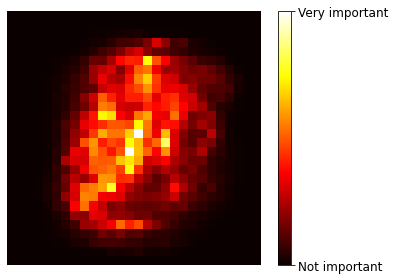

In [20]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

## 7.5 부스팅

**부스팅(booasting)** : 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법
+ 앞의 모델을 보완해나가면서 일련의 예측기를 학습
+ 에이다부스트, 그레이디언트 부스팅

### 7.5.1 에이다부스트(AdaBoost)
**방식**

이전 모델이 과소적합했던 훈련 샘플의 가중치를 높이면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 됨

**과정**
+ 첫 번째 분류기를 훈련 세트에서 훈련시키고 예측을 만듦
+ 그다음에 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높임
+ 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만듦
+ 그다음에 다시 가중치를 업데이트함

**특징**
+ 에이다부스트는 점차 더 좋아지도록 앙상블에 예측기를 추가
    + 경사 하강법(비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정)과 비슷
+ 모든 예측기가 훈련을 마치면 앙상블은 배깅이나 페이스팅과 비슷한 방식으로 예측을 만듦
+ 사이킷런은 SAMME라는 에이다부스트의 다중 클래스 버전을 사용(예측기가 클래스의 확률을 추정할 수 있다면 SAMME.R 사용)

<img src="img/7-7.png" width="500px" align='left'>  

moons 데이터셋에 훈련시킨 다섯 개의 연속된 예측기의 결정 경계
+ 잘못 분류된 샘플의 가중치는 반복마다 절반 정도만 높아짐

<img src="img/7-8.png" width="500px" align='left'>  

In [21]:
# AdaBoostClassifier을 사용해 200개의 아주 얕은 결정 트리를 기반으로 하는 에이다부스트 분류기를 훈련
# max_depth = 1 (결정 노드 1개, 리프 노드 2개)
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

### 7.5.2 그레이디언트 부스팅
**방식**

앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가
+ 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습
+ 오차에 대해 학습하는 회귀 모델이기 때문에 회귀/분류 모델에 상관없이 DecisionTreeRegressor 고정

**과정**
+ DecisionTreeRegressor를 훈련 세트에 학습
+ 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeRegressor를 훈련
+ 두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델을 훈련
+ 새로운 샘플에 대한 예측을 만들기 위해 모든 트리의 예측을 더하기

In [22]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [23]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [24]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [25]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [26]:
X_new = np.array([[0.8]])

In [27]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [28]:
y_pred

array([0.75026781])

In [29]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

그림 저장: gradient_boosting_plot


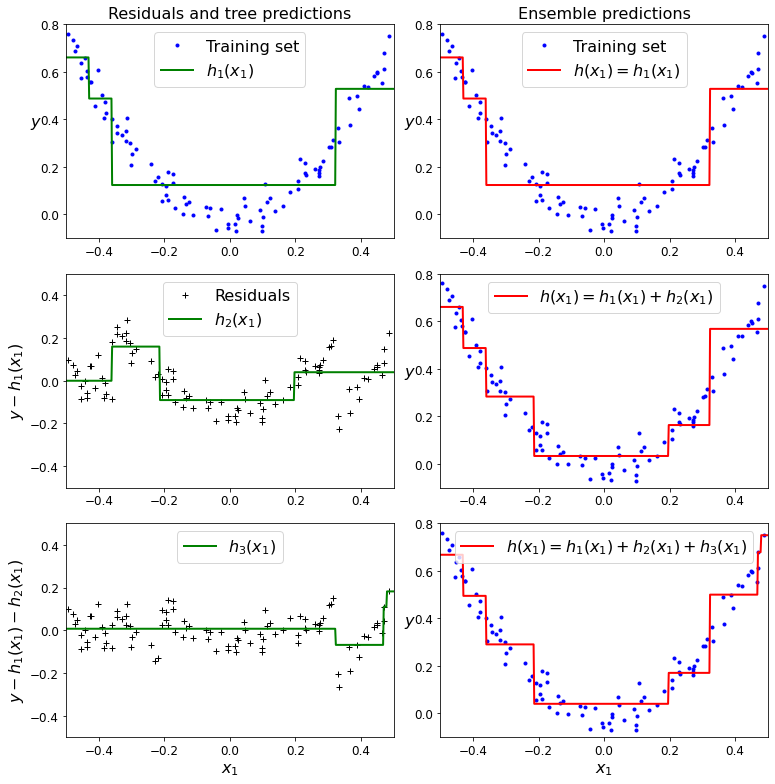

In [30]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

**GradientBoostingRegressor**
+ n_estimators, max_depth, min_samples_leaf
+ learning_rate : 각 트리의 기여 정도를 조절
    + **축소(shrinkage)**
        + 학습률 낮추면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아짐
+ loss : 최소제곱을 의미하는 'ls'가 기본값


**GradientBoostingClassifier**
+ loss : 로지스틱 손실 함수를 의미하는 'deviance'가 기본값

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [32]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

LEFT : 훈련 세트를 학습하기에는 트리가 충분하지 않음

RIGHT : 트리가 너무 많아 훈련 세트에 과대적합

그림 저장: gbrt_learning_rate_plot


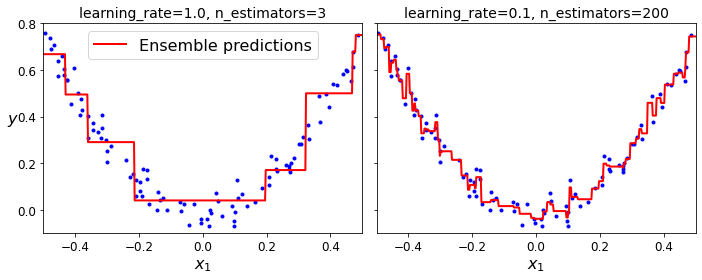

In [33]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

**조기 종료 기법**
+ staged_predict()
    + 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자를 반환
+ 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증 오차를 측정
+ 최적의 트리 수를 사용해 새로운 GBRT 앙상블을 훈련
+ warm_start = True : 사이킷런이 fit() 메서드가 호출될 떄 기존 트리를 유지하고 훈련을 추가할 수 있음

In [34]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]

bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [35]:
min_error = np.min(errors)

그림 저장: early_stopping_gbrt_plot


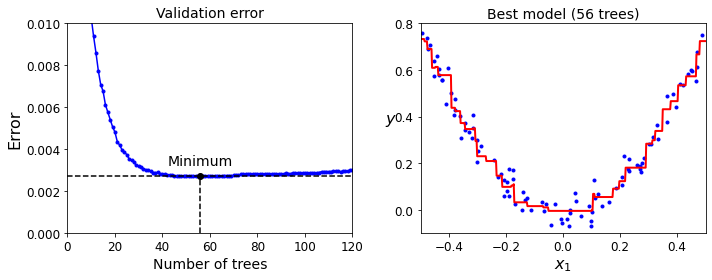

In [36]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

In [37]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

**확률적 그레이디언트 부스팅(stochastic gradient boosting)**
+ subsample : 각 트리가 훈련할 때 사용할 훈련 샘플의 비율
    + 편향이 높아지는 대신 분산이 낮아짐
    + 훈련 속도 증가

**XGBoost(extreme gradient boosting)** : 최적화된 그레이디언트 부스팅 구현
+ 매우 빠른 속도, 확장성, 이식성


**LightGBM** : 히스토그램 기반 그레이디언트 부스팅

In [38]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

C:\Users\jwshi\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [39]:
xgb_reg.fit(X_train,y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211


## 7.6 스태킹

**스태킹(stacking)** : 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신 취합하는 모델을 훈련
+ 각각 다른 값을 예측하고 마지막 예측기(블렌더 or 메타 학습기)가 이 예측을 입력으로 받아 최종 예측을 만듦
<img src="img/7-12.png" width="500px" align='left'>

**블렌더(blender) 학습 방법**
+ 홀드 아웃(hold-out) 세트를 사용
1. 훈련 세트를 두 개의 서브셋으로 나눔
2. 첫 번째 세트는 첫 번째 레이어의 예측을 훈련시키기 위해 사용
3. 첫 번째 레이어의 예측기를 사용해 두 번째 세트에 대한 예측을 만듦
+ 첫 번째 레이어의 예측을 가지고 타깃값을 예측
    
<img src="img/7-13.png" width="500px" align='left'>

+ 블렌더를 여러 개 훈련

<img src="img/7-14.png" width="500px" align='left'>

+ 각 레이어를 차례대로 실행해서 새로운 샘플에 대한 예측

<img src="img/7-15.png" width="500px" align='left'>